In [367]:
import pickle 
import pandas as pd
import matplotlib.pyplot as plt

In [353]:
# This one already good with d3331e56-40bb-4328-a7b3-57f0f1a6ec3e.pkl expert+dqn|
with open('results/11_20_56_9.pkl', 'rb') as pickle_file:
        save_dict = pickle.load(pickle_file)

In [392]:
#This is good 
with open('results/12_13_1_54.pkl', 'rb') as pickle_file:
        save_dict = pickle.load(pickle_file)

In [393]:
with open('results/12_16_9_23_try_dqn_simple.pkl.pkl', 'rb') as pickle_file:
        save_dict = pickle.load(pickle_file)

In [408]:
save_df = pd.DataFrame(save_dict)
#save_df = save_df.set_index('date')
save_df

,power_bid,price_bid,soc,power_cleared,reward,date,price_cleared,ref_price,power_dqn,cost_dqn
0,0.0,0.0,19.0,0.000000e+00,0.000000,2015-06-01 19:00:00+00:00,0.000000,0.000000,0.0,0.0
1,-750.0,80.0,20.0,-7.500000e+02,-30688.681712,2015-06-01 19:00:00+00:00,40.918242,32.546986,-750.0,80.0
2,-750.0,80.0,21.0,-7.500000e+02,-58.658032,2015-06-01 20:00:00+00:00,43.740692,37.158137,-750.0,80.0
3,80.0,46.5,22.0,-1.185773e-04,-100.000000,2015-06-01 21:00:00+00:00,47.146474,39.528146,80.0,46.5
4,80.0,46.5,23.0,6.270736e-01,-100.000000,2015-06-01 22:00:00+00:00,39.753216,43.225725,80.0,46.5
5,80.0,46.5,0.0,-1.234765e-01,-100.000000,2015-06-01 23:00:00+00:00,45.838813,48.923451,80.0,46.5
6,80.0,46.5,1.0,7.952284e+01,3697.812289,2015-06-02 00:00:00+00:00,62.379515,62.379515,80.0,46.5
7,80.0,46.5,2.0,7.869348e+01,3659.246666,2015-06-02 01:00:00+00:00,84.772015,84.772015,80.0,46.5
8,80.0,46.5,3.0,7.958504e+01,3700.704129,2015-06-02 02:00:00+00:00,85.386423,85.386423,80.0,46.5
9,80.0,46.5,4.0,7.951864e+01,3697.616845,2015-06-02 03:00:00+00:00,65.569323,62.152367,80.0,46.5


In [409]:
price_bid_charge = []
price_bid_discharge = []
for i, price_bid in enumerate(save_df['price_bid'].values):
    power_bid = save_df['power_bid'].iloc[i]
    if power_bid >= 0 :
        price_bid_discharge.append(price_bid)
        price_bid_charge.append(0)
    else:
        price_bid_charge.append(price_bid)
        price_bid_discharge.append(0)
save_df['price_bid_charge'] = price_bid_charge
save_df['price_bid_discharge'] = price_bid_discharge

Text(0.5,0,'timestep')

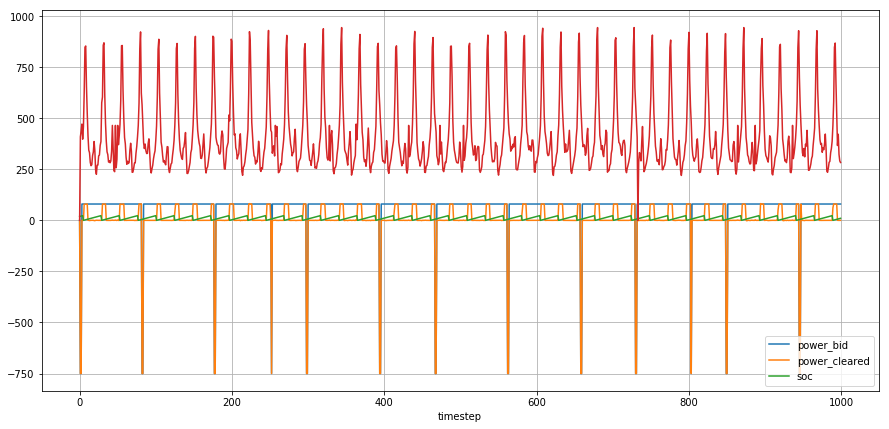

In [419]:
save_df[['power_bid', 'power_cleared', 'soc']].iloc[:1000].plot(figsize=(15, 7), grid=True)
plt.plot(save_df['price_cleared'].iloc[:1000]*10)
plt.xlabel('timestep')

Text(0.5,0,'timestep')

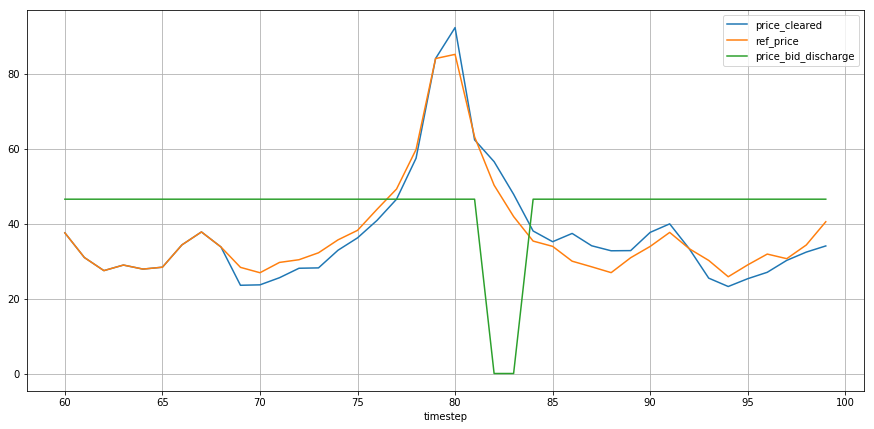

In [414]:
save_df[['price_cleared', 'ref_price', 'price_bid_discharge']].iloc[60:100].plot(figsize=(15, 7), grid=True)
plt.xlabel('timestep')

Text(0.5,0,'timestep')

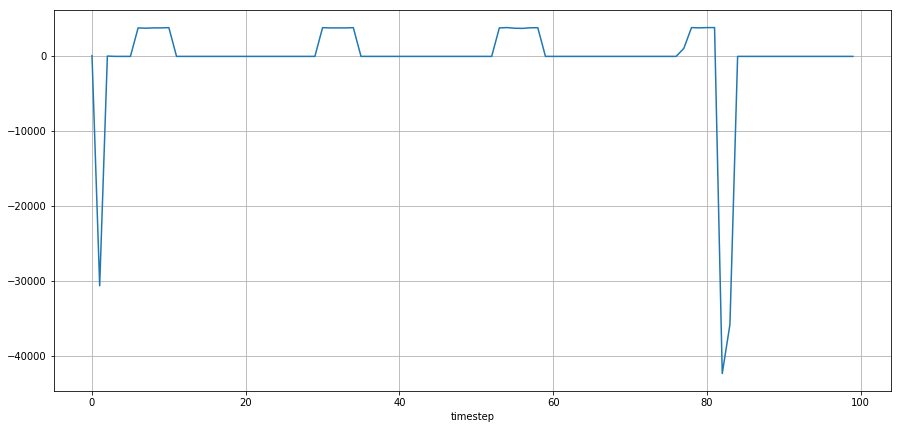

In [417]:
save_df['reward'].iloc[:100].plot(figsize=(15, 7), grid=True)
plt.xlabel('timestep')

In [415]:
save_df['reward'].mean()

-204.67522626058886

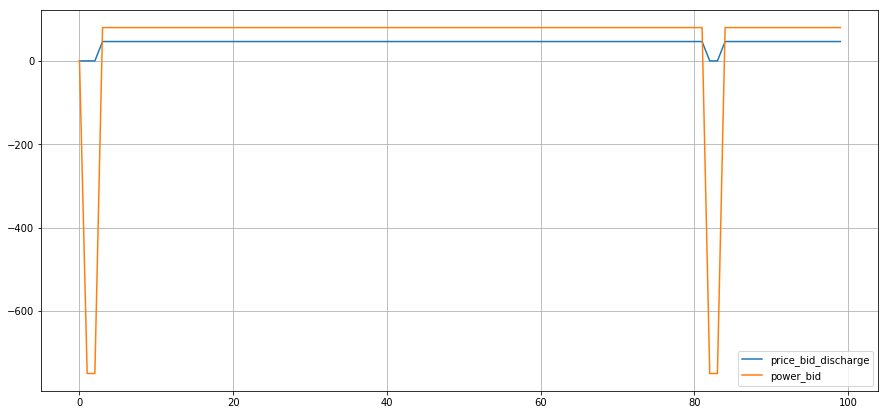

In [418]:
save_df[['price_bid_discharge', 'power_bid']].iloc[:100].plot(figsize=(15, 7), grid=True)